In [3]:
import torch
print("CUDA Available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name: ", torch.cuda.get_device_name(0))
else:
    print("CUDA not available.")

CUDA Available:  True
GPU Name:  NVIDIA GeForce RTX 4070


In [4]:
!pip install --quiet tensorflow scikit-learn matplotlib seaborn
print("✅ TensorFlow, scikit-learn, matplotlib, and seaborn installed quietly.")

✅ TensorFlow, scikit-learn, matplotlib, and seaborn installed quietly.


In [5]:
# CELL 1: Setup, GPU Configuration, and Path Definitions (UPDATED)

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2 # <-- New import for regularization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

# --- Configuration ---
DATA_DIR = 'skin_cancer_processed_augmented'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42
NUM_CLASSES = 7
INITIAL_EPOCHS = 40
DROPOUT_RATE = 0.40       # <--- INCREASED from 0.15 to 0.40 to fight overfitting
PATIENCE = 5
WEIGHT_DECAY = 0.001      # <--- ADDED L2 Weight Decay Constant
CHECKPOINT_PATH = 'best_vgg19_model_checkpoint.h5'

# Set GPU memory growth to prevent TensorFlow from allocating all GPU memory at once
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU Memory Growth enabled.")
except Exception as e:
    print(f"❌ Could not configure GPU memory growth: {e}")

tf.keras.utils.set_random_seed(RANDOM_SEED)
print("✅ TensorFlow random seed set.")
print("---")

✅ TensorFlow random seed set.
---


🚀 Loading data from disk...
Found 28731 files belonging to 7 classes.
Found 2492 files belonging to 7 classes.
Found 1285 files belonging to 7 classes.
✅ Data loaded successfully. Class names: ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'dermatofibroma', 'melanocytic_Nevi', 'melanoma', 'vascular_lesions']
---


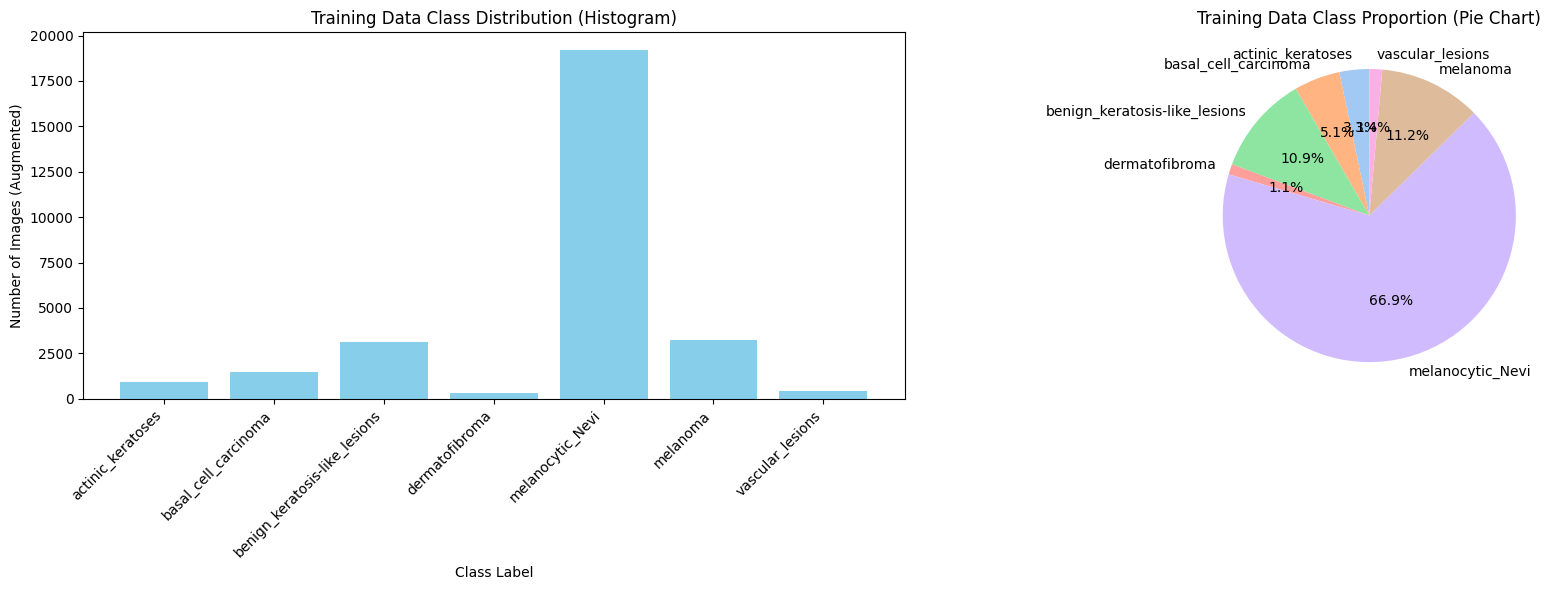

✅ Class distribution visualized and saved as 'class_distribution.png'.
---


In [6]:
# CELL 2: Data Loading and Visualization

print("🚀 Loading data from disk...")

# Load the Augmented Train Set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bicubic',
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

# Load the Processed Validation Set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bicubic',
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

# Load the Processed Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bicubic',
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

CLASS_NAMES = train_ds.class_names
print(f"✅ Data loaded successfully. Class names: {CLASS_NAMES}")
print("---")


# --- Visualization ---

# Helper function to extract all labels for plotting
def get_labels(dataset):
    all_labels = []
    for images, labels in dataset.unbatch():
        all_labels.append(np.argmax(labels.numpy()))
    return np.array(all_labels)

# Extract labels from the training set
train_labels = get_labels(train_ds)
label_counts = np.bincount(train_labels)

# Plotting
plt.figure(figsize=(18, 6))

# Subplot 1: Histogram (Class Imbalance)
plt.subplot(1, 2, 1)
plt.bar(CLASS_NAMES, label_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Training Data Class Distribution (Histogram)')
plt.ylabel('Number of Images (Augmented)')
plt.xlabel('Class Label')

# Subplot 2: Pie Chart (Proportion)
plt.subplot(1, 2, 2)
plt.pie(label_counts, labels=CLASS_NAMES, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Training Data Class Proportion (Pie Chart)')

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show() # In a local notebook, this should display the image
print("✅ Class distribution visualized and saved as 'class_distribution.png'.")
print("---")

In [11]:
# CELL 3: VGG19 Model Definition and Callbacks (UPDATED)

print("🧠 Defining VGG19 Model and Callbacks...")

# Load VGG19 pre-trained on ImageNet, without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Create the Sequential model with L2 regularization and increased Dropout
model = Sequential([
    # Data Normalization layer
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    # Base VGG19 model
    base_model,
    
    # Classification Head
    Flatten(),
    
    # Dense layer 1 with L2 regularization
    Dense(512, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY)),
    # Increased Dropout for regularization
    Dropout(DROPOUT_RATE, seed=RANDOM_SEED),
    
    # Dense layer 2 with L2 regularization (Optional intermediate layer)
    Dense(256, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY)),
    Dropout(DROPOUT_RATE, seed=RANDOM_SEED),
    
    # Final dense layer
    Dense(NUM_CLASSES, activation='softmax')
])

# --- Callbacks ---
# 1. Early Stopping (Requested patience=5)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    restore_best_weights=True, 
    verbose=1
)

# 2. Model Checkpoint 
checkpoint = ModelCheckpoint(
    CHECKPOINT_PATH, 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

print(f"✅ Model Checkpoint set to save the best model (based on val_loss) to: {CHECKPOINT_PATH}")
print(f"✅ Early Stopping set with patience={PATIENCE}.")
print("---")

🧠 Defining VGG19 Model and Callbacks...
✅ Model Checkpoint set to save the best model (based on val_loss) to: best_vgg19_model_checkpoint.h5
✅ Early Stopping set with patience=5.
---


In [12]:
# CELL 4: Training Execution

print(f"🏃 Starting training for up to {INITIAL_EPOCHS} epochs...")

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),


    loss='categorical_crossentropy',
    metrics=['accuracy']
)
 
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping, checkpoint]
)

print("✅ Training completed.")
print("---")

🏃 Starting training for up to 40 epochs...
Epoch 1/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6253 - loss: 2.4076
Epoch 1: val_loss improved from None to 1.79069, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1857s 2s/step - accuracy: 0.6618 - loss: 2.1465 - val_accuracy: 0.6850 - val_loss: 1.7907
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6845 - loss: 1.7640
Epoch 2: val_loss improved from 1.79069 to 1.62682, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1817s 2s/step - accuracy: 0.6824 - loss: 1.7163 - val_accuracy: 0.6717 - val_loss: 1.6268
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6882 - loss: 1.5783
Epoch 3: val_loss improved from 1.62682 to 1.58430, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1862s 2s/step - accuracy: 0.6892 - loss: 1.5532 - val_accuracy: 0.6589 - val_loss: 1.5843
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6965 - loss: 1.4655
Epoch 4: val_loss improved from 1.58430 to 1.51967, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1824s 2s/step - accuracy: 0.6950 - loss: 1.4507 - val_accuracy: 0.6489 - val_loss: 1.5197
Epoch 5/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6984 - loss: 1.3839
Epoch 5: val_loss improved from 1.51967 to 1.51522, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1831s 2s/step - accuracy: 0.6975 - loss: 1.3695 - val_accuracy: 0.6328 - val_loss: 1.5152
Epoch 6/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7038 - loss: 1.3140
Epoch 6: val_loss did not improve from 1.51522
898/898 ━━━━━━━━━━━━━━━━━━━━ 1840s 2s/step - accuracy: 0.7028 - loss: 1.3063 - val_accuracy: 0.6108 - val_loss: 1.5218
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7028 - loss: 1.2612
Epoch 7: val_loss improved from 1.51522 to 1.39505, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1924s 2s/step - accuracy: 0.7055 - loss: 1.2527 - val_accuracy: 0.6673 - val_loss: 1.3950
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7124 - loss: 1.2136
Epoch 8: val_loss did not improve from 1.39505
898/898 ━━━━━━━━━━━━━━━━━━━━ 1870s 2s/step - accuracy: 0.7118 - loss: 1.2092 - val_accuracy: 0.6248 - val_loss: 1.4117
Epoch 9/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7133 - loss: 1.1788
Epoch 9: val_loss improved from 1.39505 to 1.36851, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1839s 2s/step - accuracy: 0.7131 - loss: 1.1727 - val_accuracy: 0.6429 - val_loss: 1.3685
Epoch 10/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7175 - loss: 1.1422
Epoch 10: val_loss improved from 1.36851 to 1.36177, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1845s 2s/step - accuracy: 0.7180 - loss: 1.1394 - val_accuracy: 0.6276 - val_loss: 1.3618
Epoch 11/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7211 - loss: 1.1190
Epoch 11: val_loss did not improve from 1.36177
898/898 ━━━━━━━━━━━━━━━━━━━━ 1842s 2s/step - accuracy: 0.7213 - loss: 1.1166 - val_accuracy: 0.5770 - val_loss: 1.4371
Epoch 12/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7242 - loss: 1.0942
Epoch 12: val_loss did not improve from 1.36177
898/898 ━━━━━━━━━━━━━━━━━━━━ 1852s 2s/step - accuracy: 0.7244 - loss: 1.0919 - val_accuracy: 0.5843 - val_loss: 1.4209
Epoch 13/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7284 - loss: 1.0735
Epoch 13: val_loss improved from 1.36177 to 1.31537, saving model to best_vgg19_model_checkpoint.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1838s 2s/step - accuracy: 0.7269 - loss: 1.0729 - val_accuracy: 0.6384 - val_loss: 1.3154
Epoch 14/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7291 - loss: 1.0560
Epoch 14: val_loss did not improve from 1.31537
898/898 ━━━━━━━━━━━━━━━━━━━━ 1833s 2s/step - accuracy: 0.7284 - loss: 1.0562 - val_accuracy: 0.5847 - val_loss: 1.4040
Epoch 15/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7352 - loss: 1.0349
Epoch 15: val_loss did not improve from 1.31537
898/898 ━━━━━━━━━━━━━━━━━━━━ 1841s 2s/step - accuracy: 0.7335 - loss: 1.0384 - val_accuracy: 0.5927 - val_loss: 1.3745
Epoch 16/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7386 - loss: 1.0227
Epoch 16: val_loss did not improve from 1.31537
898/898 ━━━━━━━━━━━━━━━━━━━━ 1840s 2s/step - accuracy: 0.7368 - loss: 1.0235 - val_accuracy: 0.6083 - val_loss: 1.3417
Epoch 17/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7408 - loss: 1.0093
Epoch 17: val_loss did not improve f

📈 Plotting Training History...


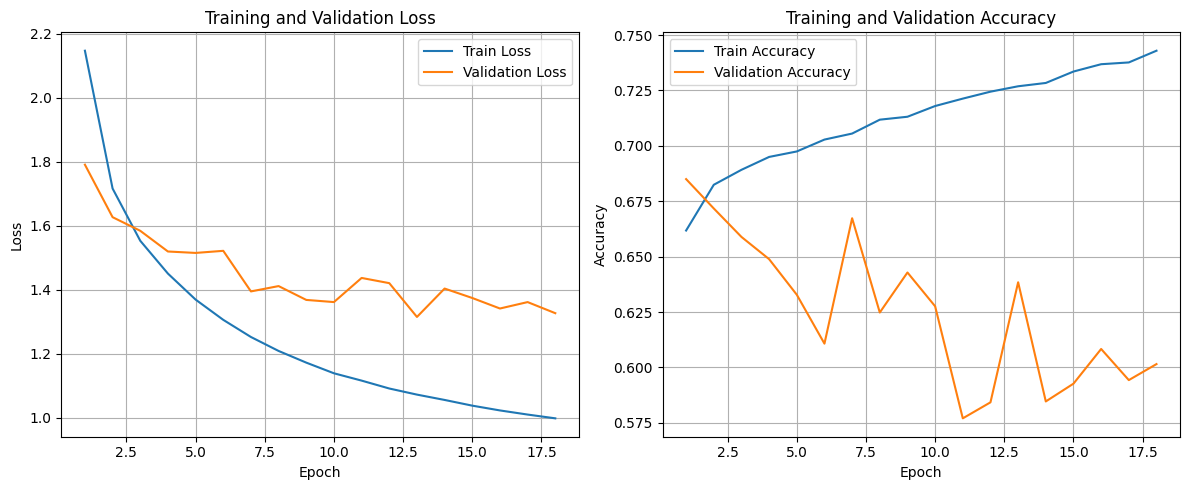

✅ Training history visualized and saved as 'training_history.png'.
---


In [13]:
# CELL 5: Training History Visualization

print("📈 Plotting Training History...")

# Extract history data
hist = history.history
epochs_trained = len(hist['loss'])

plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_trained + 1), hist['loss'], label='Train Loss')
plt.plot(range(1, epochs_trained + 1), hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_trained + 1), hist['accuracy'], label='Train Accuracy')
plt.plot(range(1, epochs_trained + 1), hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()
print("✅ Training history visualized and saved as 'training_history.png'.")
print("---")

🎯 Final Test Set Evaluation and ROC Curve Analysis...


✅ Loaded best model from checkpoint: best_vgg19_model_checkpoint.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step

--- Overall Test Metrics (using best checkpoint) ---
Overall Accuracy: 0.3844
Overall Precision: 0.1347
Overall Recall: 0.1368
Overall F1-Score: 0.1311

--- Classification Report ---
                               precision    recall  f1-score   support

            actinic_keratoses       0.02      0.05      0.03        42
         basal_cell_carcinoma       0.03      0.03      0.03        67
benign_keratosis-like_lesions       0.10      0.19      0.13       142
               dermatofibroma       0.00      0.00      0.00        14
             melanocytic_Nevi       0.66      0.51      0.58       858
                     melanoma       0.13      0.18      0.15       144
             vascular_lesions       0.00      0.00      0.00        18

                     accuracy                           0.38      1285
                    macro avg       0.13      0.14      0.13      12

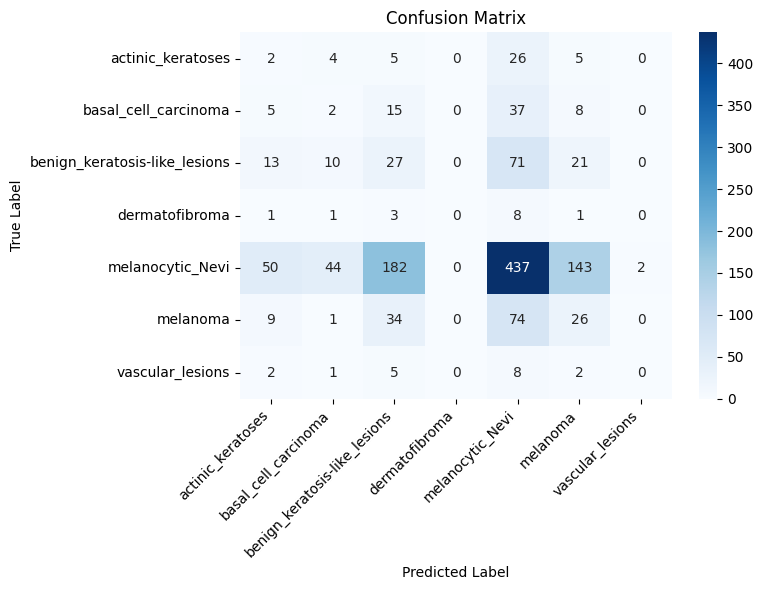

✅ Confusion Matrix visualized and saved as 'confusion_matrix.png'.

📊 Calculating and Plotting Multi-Class ROC Curves (One-vs-Rest)...


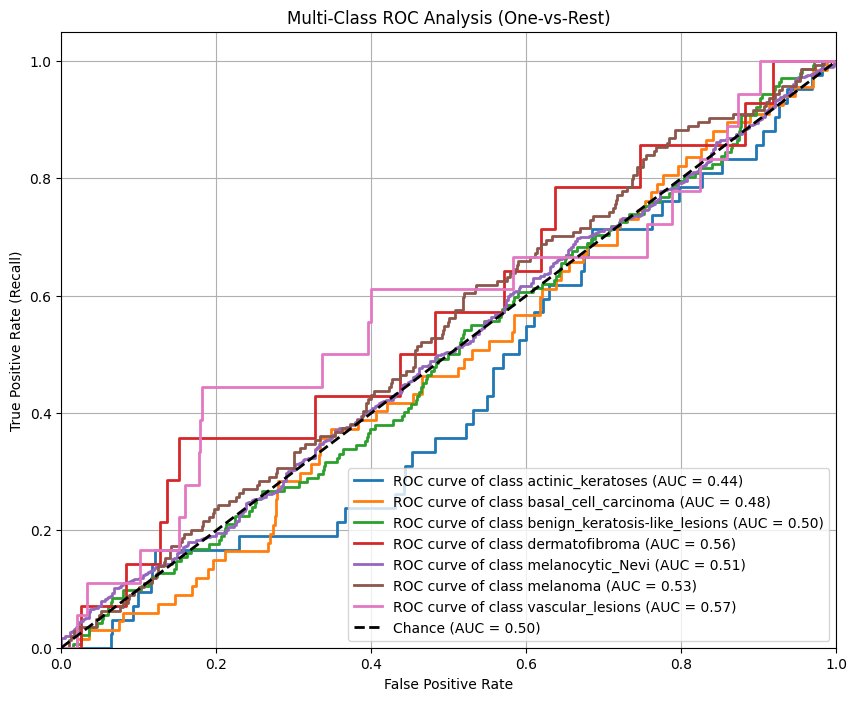

✅ ROC Curve Analysis complete. Plot saved as 'roc_curve_analysis.png'.
---


In [14]:
# CELL 6: Final Test Evaluation and Metrics (and ROC Curve Analysis)

# We need these imports for full evaluation and plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("🎯 Final Test Set Evaluation and ROC Curve Analysis...")

# 1. Load the best saved checkpoint
# Requires CHECKPOINT_PATH variable from Cell 1
best_model = tf.keras.models.load_model(CHECKPOINT_PATH)
print(f"✅ Loaded best model from checkpoint: {CHECKPOINT_PATH}")

# 2. Get true labels and predictions from the test set
# Requires test_ds variable from Cell 2 and NUM_CLASSES/CLASS_NAMES from Cell 1
test_labels_categorical = np.concatenate([y for x, y in test_ds], axis=0) # One-hot true labels
test_labels = np.argmax(test_labels_categorical, axis=1) # Integer true labels

predictions_categorical = best_model.predict(test_ds) # Predicted probabilities
predictions = np.argmax(predictions_categorical, axis=1) # Integer predicted labels


# --- PART A: Quantitative Metrics ---
print("\n--- Overall Test Metrics (using best checkpoint) ---")
print(f"Overall Accuracy: {accuracy_score(test_labels, predictions):.4f}")
print(f"Overall Precision: {precision_score(test_labels, predictions, average='macro', zero_division=0):.4f}")
print(f"Overall Recall: {recall_score(test_labels, predictions, average='macro', zero_division=0):.4f}")
print(f"Overall F1-Score: {f1_score(test_labels, predictions, average='macro', zero_division=0):.4f}")

print("\n--- Classification Report ---")
print(classification_report(test_labels, predictions, target_names=CLASS_NAMES, zero_division=0))


# --- PART B: Confusion Matrix Visualization ---
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
print("✅ Confusion Matrix visualized and saved as 'confusion_matrix.png'.")


# --- PART C: ROC Curve Analysis ---
print("\n📊 Calculating and Plotting Multi-Class ROC Curves (One-vs-Rest)...")

y_true = test_labels_categorical
y_score = predictions_categorical

plt.figure(figsize=(10, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

# Iterate over all 7 classes
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], 
             label=f'ROC curve of class {CLASS_NAMES[i]} (AUC = {roc_auc[i]:.2f})',
             linewidth=2)

# Final Plot Configuration
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Multi-Class ROC Analysis (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve_analysis.png')
plt.show()

print("✅ ROC Curve Analysis complete. Plot saved as 'roc_curve_analysis.png'.")
print("---")

🖼️ Visualizing 10 Randomly Sampled Test Predictions...


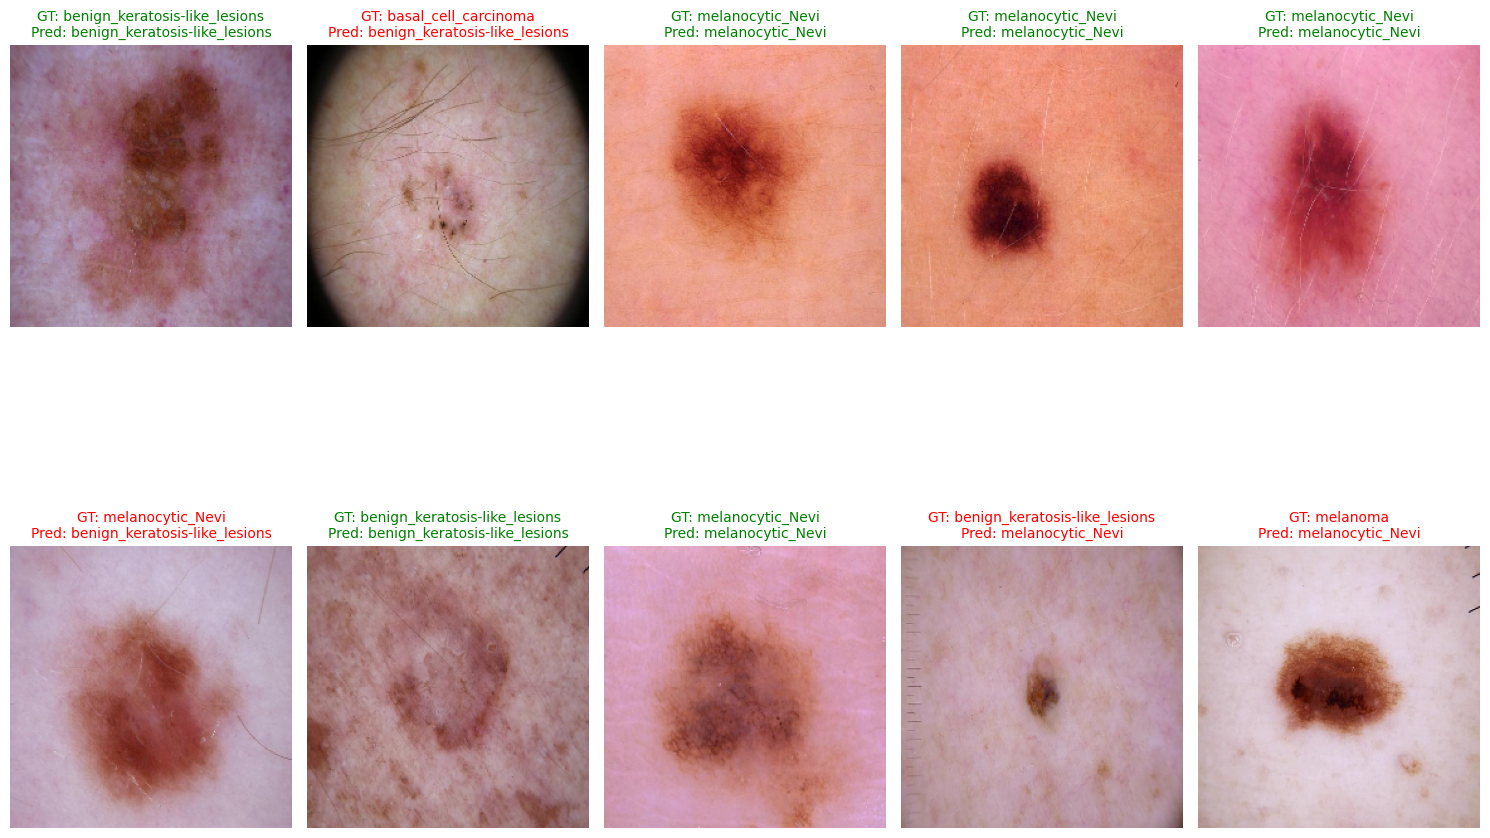

✅ Sample predictions visualized and saved as 'test_predictions_sample.png'.

🎉 The entire deep learning pipeline is complete!


In [15]:
# CELL 7: Prediction Visualization on Sampled Images

print("🖼️ Visualizing 10 Randomly Sampled Test Predictions...")

# Load all test image paths and labels from the disk for random sampling
test_image_paths = []
test_true_labels = []

# Assuming the structure is DATA_DIR/split/label/image.jpg
for class_index, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATA_DIR, 'test', class_name)
    paths = glob.glob(os.path.join(class_path, '*.jpg'))
    test_image_paths.extend(paths)
    test_true_labels.extend([class_name] * len(paths))

# Select 10 random samples
random.seed(RANDOM_SEED)
sample_indices = random.sample(range(len(test_image_paths)), 10)
sample_paths = [test_image_paths[i] for i in sample_indices]
sample_true_labels = [test_true_labels[i] for i in sample_indices]


# --- Prediction and Visualization ---
plt.figure(figsize=(15, 12))

for i, img_path in enumerate(sample_paths):
    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

    # Predict
    prediction_vector = best_model.predict(img_array, verbose=0)
    predicted_index = np.argmax(prediction_vector[0])
    predicted_label = CLASS_NAMES[predicted_index]
    
    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    
    # Determine color for title
    color = 'green' if predicted_label == sample_true_labels[i] else 'red'
    
    title = (f"GT: {sample_true_labels[i]}\n"
             f"Pred: {predicted_label}")
             
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('test_predictions_sample.png')
plt.show()

print("✅ Sample predictions visualized and saved as 'test_predictions_sample.png'.")
print("\n🎉 The entire deep learning pipeline is complete!")